# Data Visualization

This notebook is just going to be used for visualizing the radar data so that we can see how the data is structured for further use

## Data Validation

If you just want to use this notebook for data validation, jump directly down to the data validation subsection.

***NOTE*** You need to run the import statements before jumping down to that section

In [ ]:
## Imports

# Data Handling
import bz2
import sys, os
import pyart
from pyproj import Proj
import numpy as np

# Graphing
import matplotlib.pyplot as plt
from pyart.graph import RadarDisplay
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [ ]:
# Defining the data file and opening the data
# Define the path to the data file
root_dir = '../'
data_path = 'data/'
file = "KENX_latest_scan.bin"  # Replace with your file name
file_path = f"{root_dir}{data_path}{file}"
file_path = os.path.join(root_dir, data_path, file)

# Try to read the file using Py-ART
try:
    radar = pyart.io.read_nexrad_archive(file_path)
    print("Radar data loaded successfully.")
    #print(radar)  # Print radar object details

    # Example: Access radar attributes
    print(f"Station: {radar.metadata['instrument_name']}\tLatitude: {radar.latitude['data'][0]}, Longitude: {radar.longitude['data'][0]}")  # Station name
    print("Radar fields:", radar.fields.keys())
    print("Radar elevation angles:", radar.elevation['data'])
    print(f"Number of sweeps: {len(radar.sweep_number['data'])}")
except Exception as e:
    print(f"Error reading radar file: {e}")


In [ ]:
radar.get_field(2, 'reflectivity')

## Converting data onto Lat/Lon grid

In [ ]:
# Define grid parameters
grid_shape = (1, 500, 500)  # (vertical levels, lat points, lon points)
grid_limits = ((0, 2000), (-150000, 150000), (-150000, 150000))  # Height in meters, lat/lon limits in meters

# Perform grid conversion
grid = pyart.map.grid_from_radars(
    radar, 
    grid_shape=grid_shape, 
    grid_limits=grid_limits,
    fields=['reflectivity']  # Replace with desired field
)

# Inspect grid metadata
print("Grid Metadata:")
print(f"Grid shape: {grid.fields['reflectivity']['data'].shape}")
print(f"Grid center: {grid.origin_latitude['data'][0]}, {grid.origin_longitude['data'][0]}")


In [ ]:
grid.fields['reflectivity'] 

## Plotting data

In [ ]:
# Extract data
lat = grid.point_latitude['data']
lon = grid.point_longitude['data']
reflectivity = grid.fields['reflectivity']['data'][0]  # Single vertical level

In [ ]:
np.shape(lat.squeeze()), np.shape(lon.squeeze()), np.shape(reflectivity)
lon.squeeze()[:][0].min(), lon.squeeze()[:][0].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max()
#radar.time['units'].split(' ')[-1] 

In [ ]:
# Function used to create the map subplot backgrounds over a specified subdomain
def plot_subset_background(ax, lonmin, lonmax, latmin, latmax):
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

In [ ]:
# Plot
crs = ccrs.LambertConformal(central_longitude=radar.longitude['data'][0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),constrained_layout=True,
                            subplot_kw={'projection': crs})
plot_subset_background(axes, lon.squeeze()[:][0].min(), lon.squeeze()[:][-1].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max())
cb1 = axes.pcolormesh(lon.squeeze(), lat.squeeze(), reflectivity, shading='auto', cmap='pyart_NWSRef', vmin=-10, vmax=80, transform=ccrs.PlateCarree())
fig.colorbar(cb1, ax = axes, shrink=0.75).set_label('Reflectivity (dBZ)')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')
axes.set_title('%s Reflectivity at %s'%(radar.metadata['instrument_name'],radar.time['units'].split(' ')[-1] ))


# Data Validation

This section is supposed to be used for quickly validating any radar data

In [5]:
# User defined variables
field_name = 'velocity'
file = "KLBB_20250425-012509.bin"

### Precursor stuff

This is where I will put everything I need so that you can jump straight to the data valid section

In [6]:
## Imports

# Data Handling
import bz2
import sys, os
import pyart
from pyproj import Proj
import numpy as np

# Graphing
import matplotlib.pyplot as plt
from pyart.graph import RadarDisplay
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [7]:
# Function used to create the map subplot backgrounds over a specified subdomain
def plot_subset_background(ax, lonmin, lonmax, latmin, latmax):
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

In [8]:
cmaps = {
    'reflectivity': {'cmap' : 'pyart_NWSRef', 'norm': (0,75)},
    'velocity': {'cmap' : 'pyart_NWSVel', 'norm' : (-30,30)},
    'spectrum_width': {'cmap' : 'pyart_NWS_SPW', 'norm' : (0,10)},
    'differential_reflectivity': {'cmap' : 'pyart_RefDiff', 'norm' : (-5,5)},
    'differential_phase': {'cmap' : 'pyart_SCook18', 'norm' : (0,180)},
    'cross_correlation_ratio': {'cmap' : 'pyart_Carbone42', 'norm' : (0,1)},
    'clutter_filter_power_removed': {'cmap' : 'pyart_NWSRef', 'norm': (0,75)}
}

In [9]:
# File IO
root_dir = '../'
data_path = 'data/'
file_path = f"{root_dir}{data_path}{file}"
file_path = os.path.join(root_dir, data_path, file)
# Try to read the file using Py-ART
try:
    radar = pyart.io.read_nexrad_archive(file_path)
    print("Radar data loaded successfully.")
    #print(radar)  # Print radar object details

    # Example: Access radar attributes
    print(f"Station: {radar.metadata['instrument_name']}\tLatitude: {radar.latitude['data'][0]}, Longitude: {radar.longitude['data'][0]}")  # Station name
    print("Radar fields:", radar.fields.keys())
    print("Radar elevation angles:", radar.elevation['data'])
    print(f"Number of sweeps: {len(radar.sweep_number['data'])}")
except Exception as e:
    print(f"Error reading radar file: {e}")

Radar data loaded successfully.
Station: KLBB	Latitude: 33.65414047241211, Longitude: -101.81416320800781
Radar fields: dict_keys(['differential_phase', 'clutter_filter_power_removed', 'reflectivity', 'velocity', 'differential_reflectivity', 'spectrum_width', 'cross_correlation_ratio'])
Radar elevation angles: [ 0.64819336  0.670166    0.6124878  ... 19.508972   19.484253
 19.47052   ]
Number of sweeps: 23


In [10]:
# Data Pre-processing

# Define grid parameters
grid_shape = (1, 500, 500)  # (vertical levels, lat points, lon points)
grid_limits = ((0, 2000), (-150000, 150000), (-150000, 150000))  # Height in meters, lat/lon limits in meters
# Perform grid conversion
grid = pyart.map.grid_from_radars(
    radar, 
    grid_shape=grid_shape, 
    grid_limits=grid_limits,
    fields=[field_name]  # Replace with desired field
)

lat = grid.point_latitude['data']
lon = grid.point_longitude['data']
field_data = grid.fields[field_name]['data'][0]  # Single vertical level

print(np.shape(lat.squeeze()), np.shape(lon.squeeze()), np.shape(field_data))
lon.squeeze()[:][0].min(), lon.squeeze()[:][0].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max()

(500, 500) (500, 500) (500, 500)


(np.float64(-103.40991944031096),
 np.float64(-100.21840697570468),
 np.float64(32.294869964494524),
 np.float64(35.00312347285169))

In [18]:
print("field_data min/max:", field_data.min(), field_data.max())

field_data min/max: -26.5 26.5


In [ ]:
print("Field: %s\tCmap: %s\tNorm: %s,%s"%(field_name, cmaps[field_name]['cmap'], str(cmaps[field_name]['norm'][0]), str(cmaps[field_name]['norm'][1])))
print("Grid data: Min: %s\tMax: %s"%(np.nanmin(field_data), np.nanmax(field_data))) 
#print(cmaps[field_name])

Field: velocity	Cmap: pyart_NWSVel	Norm: -30,30
Grid data: Min: -26.5	Max: 26.5
Using norm: -30, 30


Text(0, 0.5, 'Latitude')

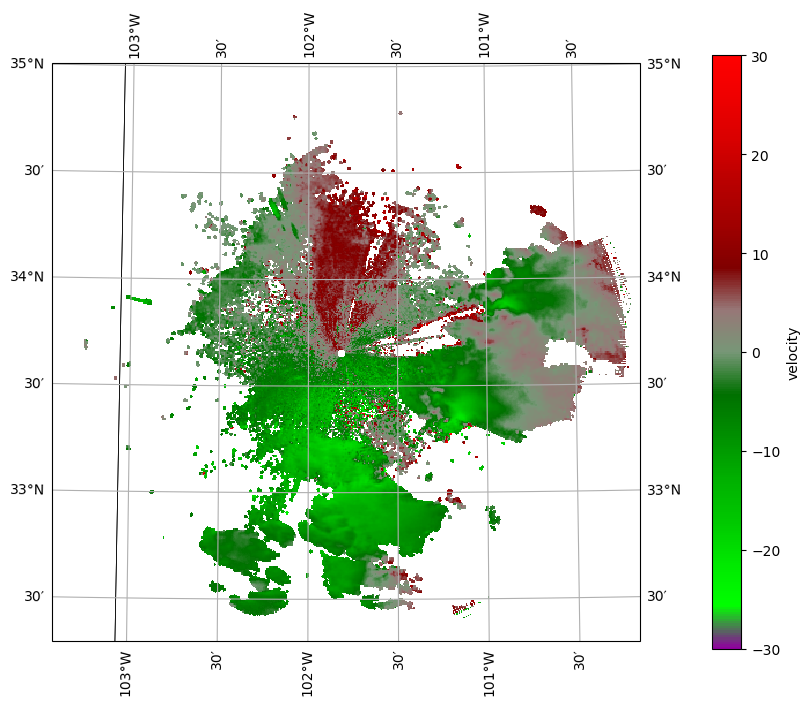

In [12]:
# Plotting

# Plot
crs = ccrs.LambertConformal(central_longitude=radar.longitude['data'][0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),constrained_layout=True,
                            subplot_kw={'projection': crs})
plot_subset_background(axes, lon.squeeze()[:][0].min(), lon.squeeze()[:][-1].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max())
cb1 = axes.pcolormesh(lon.squeeze(), lat.squeeze(), field_data, cmap=cmaps[field_name]['cmap'], 
                    vmin=cmaps[field_name]['norm'][0], vmax=cmaps[field_name]['norm'][1], transform=ccrs.PlateCarree())
fig.colorbar(cb1, ax = axes, shrink=0.75).set_label(field_name)
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')
#axes.set_title('%s Reflectivity at %s'%(radar.metadata['instrument_name'],radar.time['units'].split(' ')[-1] ))

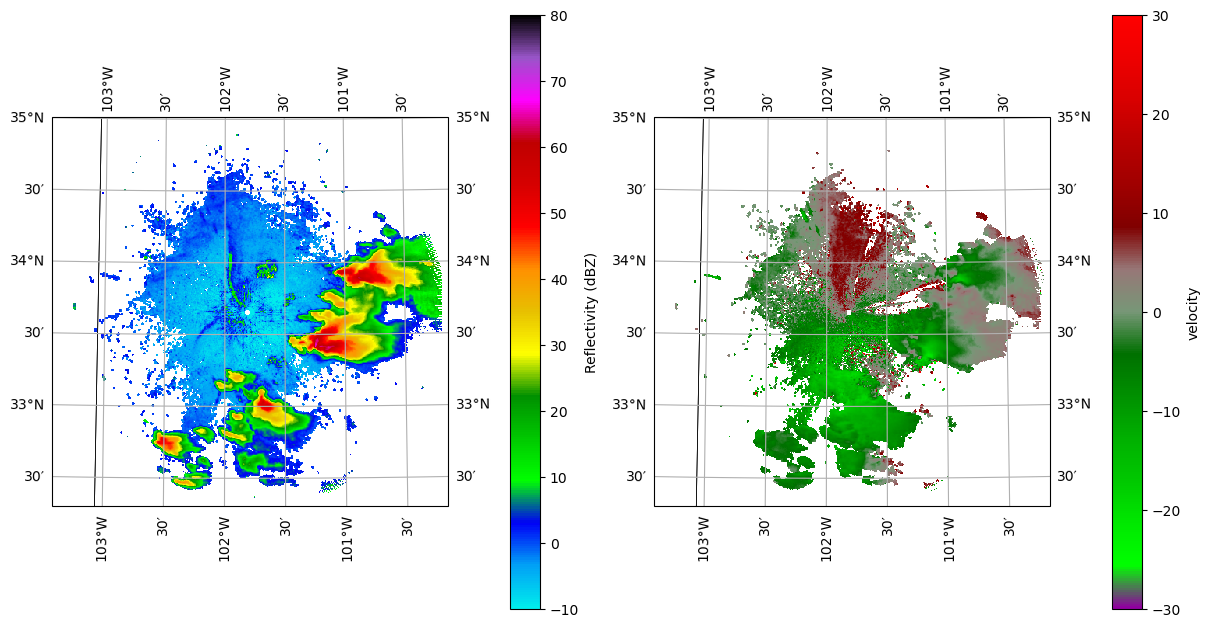

In [14]:
# Doing everything to generate a side-by-side plot with field and reflectivity
refgrid = pyart.map.grid_from_radars(
    radar, 
    grid_shape=grid_shape, 
    grid_limits=grid_limits,
    fields=['reflectivity']  # Replace with desired field
)
ref = refgrid.fields['reflectivity']['data'][0]  # Single vertical level

crs = ccrs.LambertConformal(central_longitude=radar.longitude['data'][0])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8),constrained_layout=True,
                            subplot_kw={'projection': crs})

# Plot Reflectivity
plot_subset_background(axes[0], lon.squeeze()[:][0].min(), lon.squeeze()[:][-1].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max())
cb1 = axes[0].pcolormesh(lon.squeeze(), lat.squeeze(), ref, shading='auto', cmap='pyart_NWSRef', vmin=-10, vmax=80, transform=ccrs.PlateCarree())
fig.colorbar(cb1, ax = axes[0], shrink=0.75).set_label('Reflectivity (dBZ)')

# Plot Field Data
plot_subset_background(axes[1], lon.squeeze()[:][0].min(), lon.squeeze()[:][-1].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max())
cb1 = axes[1].pcolormesh(lon.squeeze(), lat.squeeze(), field_data, shading='auto', cmap=cmaps[field_name]['cmap'], 
                    vmin=cmaps[field_name]['norm'][0], vmax=cmaps[field_name]['norm'][1], transform=ccrs.PlateCarree())
fig.colorbar(cb1, ax = axes[1], shrink=0.75).set_label(field_name)
#axes.set_xlabel('Longitude')
#axes.set_ylabel('Latitude')